# Install Packages

In [3]:
!pip install textblob
!python -m textblob.download_corpora



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Finished.


[nltk_data] Downloading package brown to C:\Users\skibret/nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\skibret/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\skibret/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\skibret/nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\skibret/nltk_data...
[nltk_data]   Unzipping corpora\conll2000.zip.
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\skibret/nltk_data...
[nltk_data]   Unzipping corpora\movie_reviews.zip.


# Load Data

In [7]:
import pandas as pd
import os

# Load news data
df_news = pd.read_csv('../data/raw_data/raw_analyst_ratings/raw_analyst_ratings.csv')
df_news['date'] = pd.to_datetime(df_news['date'], format="mixed", utc=True)
df_news['date_only'] = df_news['date'].dt.date

# Load indicator data
tickers = ['apple', 'amazon', 'meta', 'microsoft', 'nvidia', 'tesla']
indicator_data = {}

for ticker in tickers:
    path = f'../data/cleaned_data/indicators/{ticker}_indicators.csv'
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df['date_only'] = df['Date'].dt.date
    indicator_data[ticker] = df

# Confirm load
print("News rows:", df_news.shape)
print("Indicator files loaded:", list(indicator_data.keys()))


News rows: (1407328, 7)
Indicator files loaded: ['apple', 'amazon', 'meta', 'microsoft', 'nvidia', 'tesla']


# Filter out only the 6 companies data

In [8]:
# Stock ticker mapping from stock column
ticker_map = {
    'AAPL': 'apple',
    'AMZN': 'amazon',
    'FB': 'meta',
    'MFT': 'microsoft',
    'NVDA': 'nvidia',
    'TSLA': 'tesla'
}

df_news = df_news[df_news['stock'].isin(ticker_map.keys())]
df_news['ticker_name'] = df_news['stock'].map(ticker_map)

# Confirm
df_news[['stock', 'ticker_name', 'date_only']].head()


,stock,ticker_name,date_only
6680,AAPL,apple,2020-06-10
6681,AAPL,apple,2020-06-10
6682,AAPL,apple,2020-06-10
6683,AAPL,apple,2020-06-10
6684,AAPL,apple,2020-06-10


# Match the time by filtering all over again

In [9]:
# Get min/max from news
min_date = df_news['date_only'].min()
max_date = df_news['date_only'].max()

# Filter all stock data to match news date range
for ticker in tickers:
    df = indicator_data[ticker]
    df_filtered = df[(df['date_only'] >= min_date) & (df['date_only'] <= max_date)].copy()
    indicator_data[ticker] = df_filtered

# Confirm one
indicator_data['apple'][['Date', 'Close']].head()


,Date,Close
7296,2009-11-11,7.258929
7297,2009-11-12,7.213929
7298,2009-11-13,7.301786
7299,2009-11-16,7.379643
7300,2009-11-17,7.392857


# Conduct Sentiment Analysis and Aggregate if Multiple entries in a single day

In [10]:
from textblob import TextBlob

# Compute sentiment polarity
df_news['sentiment'] = df_news['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Aggregate sentiment by ticker and date
sentiment_daily = df_news.groupby(['ticker_name', 'date_only'])['sentiment'].mean().reset_index()
sentiment_daily.rename(columns={'date_only': 'Date'}, inplace=True)

# Confirm sample
sentiment_daily.head()


,ticker_name,Date,sentiment
0,amazon,2020-04-27,0.100000
1,amazon,2020-04-28,0.057396
2,amazon,2020-04-29,0.002433
3,amazon,2020-04-30,0.082699
4,amazon,2020-05-01,0.041796


# Calculate Daily Stock Returns


In [11]:
for ticker in tickers:
    df = indicator_data[ticker]
    df = df.sort_values('Date').copy()
    df['daily_return'] = df['Close'].pct_change()
    indicator_data[ticker] = df

# Confirm one
indicator_data['tesla'][['Date', 'Close', 'daily_return']].head()


,Date,Close,daily_return
0,2010-06-29,1.592667,NaN
1,2010-06-30,1.588667,-0.002511
2,2010-07-01,1.464000,-0.078473
3,2010-07-02,1.280000,-0.125683
4,2010-07-06,1.074000,-0.160937


# Correlation Analysis between news and stock returns

C:\Users\skibret\AppData\Local\Temp\ipykernel_36448\424644801.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price['Date'] = pd.to_datetime(df_price['Date'])
C:\Users\skibret\AppData\Local\Temp\ipykernel_36448\424644801.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sent['Date'] = pd.to_datetime(df_sent['Date'])


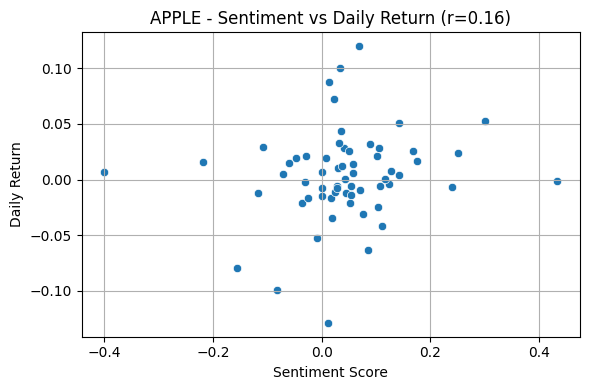

C:\Users\skibret\AppData\Local\Temp\ipykernel_36448\424644801.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price['Date'] = pd.to_datetime(df_price['Date'])
C:\Users\skibret\AppData\Local\Temp\ipykernel_36448\424644801.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sent['Date'] = pd.to_datetime(df_sent['Date'])


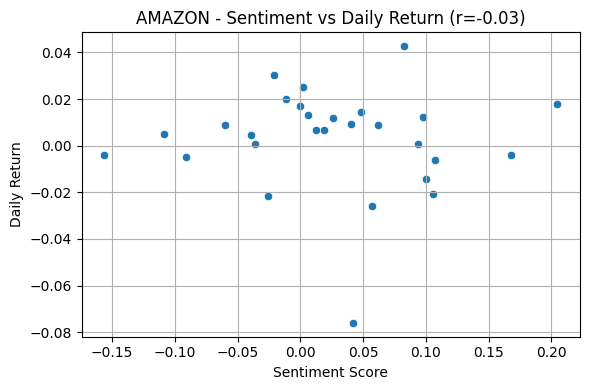

C:\Users\skibret\AppData\Local\Temp\ipykernel_36448\424644801.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price['Date'] = pd.to_datetime(df_price['Date'])
C:\Users\skibret\AppData\Local\Temp\ipykernel_36448\424644801.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sent['Date'] = pd.to_datetime(df_sent['Date'])


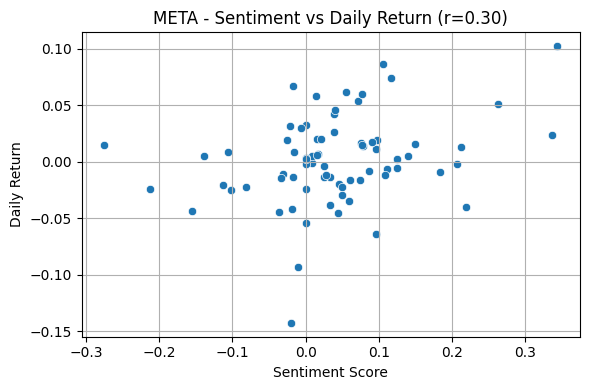

C:\Users\skibret\AppData\Local\Temp\ipykernel_36448\424644801.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price['Date'] = pd.to_datetime(df_price['Date'])
C:\Users\skibret\AppData\Local\Temp\ipykernel_36448\424644801.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sent['Date'] = pd.to_datetime(df_sent['Date'])


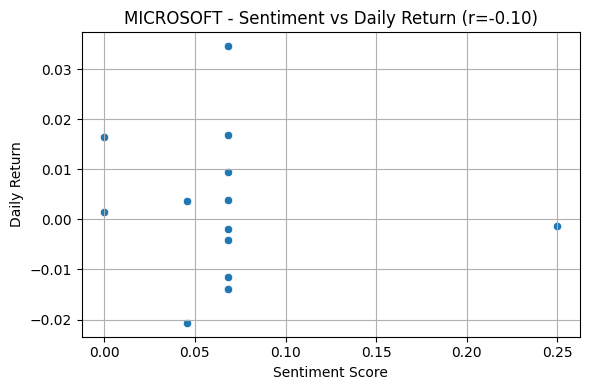

C:\Users\skibret\AppData\Local\Temp\ipykernel_36448\424644801.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price['Date'] = pd.to_datetime(df_price['Date'])
C:\Users\skibret\AppData\Local\Temp\ipykernel_36448\424644801.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sent['Date'] = pd.to_datetime(df_sent['Date'])


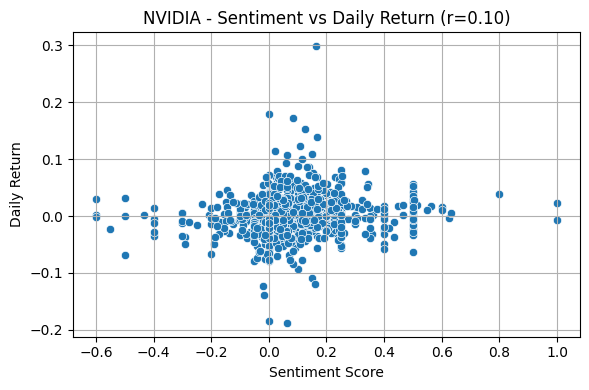

C:\Users\skibret\AppData\Local\Temp\ipykernel_36448\424644801.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price['Date'] = pd.to_datetime(df_price['Date'])
C:\Users\skibret\AppData\Local\Temp\ipykernel_36448\424644801.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sent['Date'] = pd.to_datetime(df_sent['Date'])


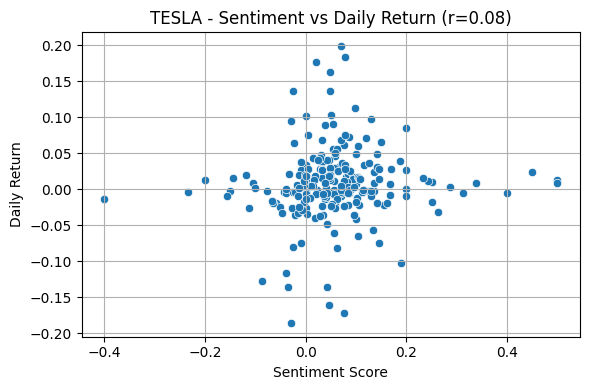

,ticker,correlation
0,APPLE,0.158900
1,AMAZON,-0.029749
2,META,0.295056
3,MICROSOFT,-0.100746
4,NVIDIA,0.103817
5,TESLA,0.082690


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

results = []

for ticker in tickers:
    df_price = indicator_data[ticker][['Date', 'daily_return']]
    df_sent = sentiment_daily[sentiment_daily['ticker_name'] == ticker]

    df_price['Date'] = pd.to_datetime(df_price['Date'])
    df_sent['Date'] = pd.to_datetime(df_sent['Date'])

    merged = pd.merge(df_price, df_sent, on='Date')
    correlation = merged['sentiment'].corr(merged['daily_return'])

    results.append({'ticker': ticker.upper(), 'correlation': correlation})
    
    # Optional: Plot
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x='sentiment', y='daily_return', data=merged)
    plt.title(f"{ticker.upper()} - Sentiment vs Daily Return (r={correlation:.2f})")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Daily Return")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Final summary
pd.DataFrame(results)
